# Wikipedia trail

- Look at the page
[Wikipedia:Getting_to_Philosophy](https://en.wikipedia.org/wiki/Wikipedia:Getting_to_Philosophy)
on the right you can see a script doing the crawl.
- Do a Google search for the script ```scraper.py```

You should get to [this page](https://medium.com/tech-insider/task-crawling-first-link-of-wikipedia-recursively-to-reach-the-philosophy-page-9f5bcc770a60).
Now copy the script and try to get it to work!!!

---

## Discussion

Web pages are created from databases by robots.
Sometimes the format of the web page changes 
and so the crawler won't find what you are looking for.
This script no longer works but it should be easy
for you to fix it.

---

What-back-end-infrastructure for [wikipedia](https://www.quora.com/What-back-end-infrastructure-technologies-does-Wikipedia-use)

Probably Wikimedia servers is a good place to start looking at how the backend works. Its pretty complex. Some of the components include

- Master SQL database running MariaDB.
- Several Slave databases also running MariaDB.
- Application Servers running Apache and MediaWiki.
- HTTP Cache servers which serve pre compiled pages. Running Varnish HTTP Cache
- Load balancing systems. running LVS





In [36]:
import string

philosophy = {x : [] for x in string.ascii_uppercase}
not_philosophy = {x : [] for x in string.ascii_uppercase}
failed = {x : [] for x in string.ascii_uppercase}

# This is a simple cache

Caching urls locally is a standard stategy 
to avoid unnecessary http requests and associated latency.

https://web.dev/http-cache/

In [328]:
cache = {x: [] for x in "success failed aborted log".split()}

def chk_cache(x : list):
    for name, cc in cache.items():
        if name == 'log': continue
        #print(cc[:5])
        if x[-1] in cc: 
            print("found in " + name)
            add_cache(name, x[:-1])
            return True
    return False
    
def add_cache(name, x:list):
    print('Done adding to ' + name)
    cache[name].extend(x)
    cache['log'].append([len(_) for _ in cache.values() ])
        

In [327]:
class Cache():
    
    def __init__(self, name='philox'):
        self.caches = {x: [] for x in "success failed aborted".split()}
        # split this off
        self.log = []

    def find(self, x : list):
        for name, cc in self.caches.items():
            if x[-1] in cc: 
                print("found in " + name)
                self.add(name, x[:-1])
                return True
        return False
    
    def add(self,name, x:list):
        print('Done adding to ' + name)
        self.caches[name].extend(x)
        self.log.append([len(_) for _ in self.caches.values() ])
        
    def dump(self,name):
        import json
        with open(name + '.json','w') as fp:
            json.dump(self.caches, fp)
            
    def load(self,name):
        with open(name + ".json",'r') as fp:
            uu = json.load(fp)
        
        

In [289]:
chk_cache([start_url])

False

In [291]:
len(cache['success'])

0

# Serialising the results

I used to use the pickle module 
but now I generally just dump a dictionary 
as a json file.

I can load it back in like this

In [361]:
import json

with open("./philo3.json",'r') as fp:
    uu = json.load(fp)
    

In [363]:
cache = uu

In [362]:
len(uu['success'])


934

In [372]:
import time, re
import urllib

#import bs4
import requests


# I changed so I don't use bs4
# extract paragraphs
pp = re.compile('<p>(.*?)</p>', re.DOTALL)
pax = re.compile(r'<a href="(.*?)".*?>(.*?)</a>', re.DOTALL)
# this is a better pattern extract links outside of the page
pax = re.compile(r'<a href="([^#]*?)".*?>(.*?)</a>', re.DOTALL)

def find_first(url, debug=False):
    # this function defines 2 functions
    # in its **local** scope 
    
    def bad_lk(x):
        # I don't know about the "_" 
        #return ':' in x   or ('Help:' in x) or ('File:' in x)
        if not x : return True
        return ':' in x  or x[-1] == "_" or ('Help:' in x) or ('File:' in x)
    
    def remove_text_between_parens(text):
        #https://stackoverflow.com/questions/37528373/
        n = 1  
        while n:
            # remove non-nested/flat balanced parts
            text, n = re.subn(r'\([^()]*\)', '', text) 
        return text
    
    response = requests.get(url)

    html = remove_text_between_parens(response.text)
    
    # sometimes there are none like for Categories
    paras = pp.findall(html)
    if not paras: return
    
    #print(paras)
    
    # this is a primitive filter 
    # I added this  so that we never get to Categories
    # or get something from the navigation sidebar
    for para in paras:
        
        lks = [lk for lk in pax.findall(para) ]
        if debug: 
            print(lks)
            print(para)
        lks = [_ for _ in lks if not bad_lk( _[0])]
        if len(lks) > 1: break
    
    try:
        article_link = lks[0]
        #I wouldn't import urllib just to do this
        return urllib.parse.urljoin('https://en.wikipedia.org/', article_link[0])
    except:
        return None


def continue_crawl(search_history, 
                   target_url, 
                   max_steps=50):
    
    curr_url = search_history[-1]
    print(curr_url)
    initial = curr_url.split('/')[-1][0].upper()
    
    if curr_url == target_url:
        add_cache('success', search_history)
        
    elif len(search_history) > max_steps:
        add_cache('aborted', search_history)
        
    elif curr_url in search_history[:-1]:
        print("already visited: failed")
        add_cache('failed', search_history)
        
    elif chk_cache(search_history) : 
        return False
    
    else:
        return True
    # bit cheeky
    return False

def follow_chain(start_url="https://en.wikipedia.org/wiki/Special:Random"):
    target_url = "https://en.wikipedia.org/wiki/Philosophy"

    article_chain = [start_url]
    first_run = True

    while continue_crawl(article_chain, target_url): 

        first_link = find_first(article_chain[-1])
        # not pretty 
        if first_run : 
            article_chain=[]
            first_run = False

        if not first_link:
            lk = article_chain[-1] if article_chain else "unknown"
            print("We've arrived at an article with no links, aborting!" + lk)
            add_cache('failed', article_chain)
            break

        article_chain.append(first_link)

        # slow down otherwise wiki server will block you
        time.sleep(2) 

for _ in range(200):
    #print('>>> ' + str(_) )
    follow_chain()
    print(cache['log'][-1])
    


https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Commander_of_the_Order_of_the_British_Empire
https://en.wikipedia.org/wiki/Order_of_chivalry
found in success
Done adding to success
[1301, 313, 0, 623]
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/UCI_Track_Cycling_World_Cup_Classics
https://en.wikipedia.org/wiki/UCI_Track_Cycling_World_Championships
https://en.wikipedia.org/wiki/World_championship
https://en.wikipedia.org/wiki/Ranking
https://en.wikipedia.org/wiki/Order_theory
https://en.wikipedia.org/wiki/Mathematics
found in failed
Done adding to failed
[1301, 318, 0, 624]
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Prague
https://en.wikipedia.org/wiki/List_of_cities_in_the_Czech_Republic
https://en.wikipedia.org/wiki/Obec
https://en.wikipedia.org/wiki/Czech_language
https://en.wikipedia.org/wiki/West_Slavic_languages
https://en.wikipedia.org/wiki/Slavic_languages
https://en.wikipedia.org/wiki/Indo

In [342]:
cache['failed'] = []

In [358]:
r = requests.get(url = "https://en.wikipedia.org/wiki/Event_", 
           headers = {'referer' : "https://en.wikipedia.org/wiki/Causality"})

In [360]:
with open("tt.html","w") as fp:
    fp.write(r.text)

In [343]:
follow_chain( start_url ="https://en.wikipedia.org/wiki/Analysis")

https://en.wikipedia.org/wiki/Analysis
https://en.wikipedia.org/wiki/Complexity
https://en.wikipedia.org/wiki/System
https://en.wikipedia.org/wiki/Interaction
https://en.wikipedia.org/wiki/Causality
https://en.wikipedia.org/wiki/Past
https://en.wikipedia.org/wiki/Present
https://en.wikipedia.org/wiki/Time
https://en.wikipedia.org/wiki/Sequence
https://en.wikipedia.org/wiki/Mathematics
https://en.wikipedia.org/wiki/Number_theory
https://en.wikipedia.org/wiki/Pure_mathematics
https://en.wikipedia.org/wiki/Mathematics
already visited: failed
Done adding to failed


In [324]:
follow_chain( start_url ="https://en.wikipedia.org/wiki/John_F._Kennedy")

https://en.wikipedia.org/wiki/John_F._Kennedy
https://en.wikipedia.org/wiki/President_of_the_United_States
https://en.wikipedia.org/wiki/Head_of_state
https://en.wikipedia.org/wiki/Persona
https://en.wikipedia.org/wiki/Character_
We've arrived at an article with no links, aborting!https://en.wikipedia.org/wiki/Character_
Done adding to failed


In [334]:
#find_first('https://en.wikipedia.org/wiki/Persona')

In [335]:
s, f, a, l = zip(*cache['log'])

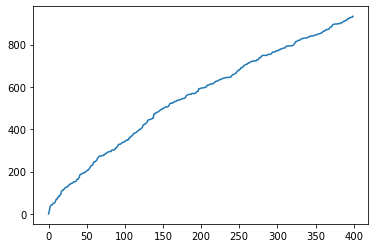

In [338]:
import numpy as np
import matplotlib.pyplot as plt
s = np.array(s)
f = np.array(f)
#plt.plot(s/(f +1));
plt.plot(s);


In [339]:
uu = list(set(cache["failed"]))
uu

['https://en.wikipedia.org/wiki/List_of_cities_in_China',
 'https://en.wikipedia.org/wiki/Photosynthesis',
 'https://en.wikipedia.org/wiki/Marine_protected_area',
 'https://en.wikipedia.org/wiki/Guideline',
 'https://en.wikipedia.org/wiki/Aptitude',
 'https://en.wikipedia.org/wiki/New_Zealand_Trade_and_Enterprise',
 'https://en.wikipedia.org/wiki/Fossil',
 'https://en.wikipedia.org/wiki/New_York_City',
 'https://en.wikipedia.org/wiki/Trace_fossil',
 'https://en.wikipedia.org/wiki/John_F._Kennedy_Jr.',
 'https://en.wikipedia.org/wiki/Sin%C3%A9ad_O%27Connor',
 'https://en.wikipedia.org/wiki/Space',
 'https://en.wikipedia.org/wiki/Bowling_ball',
 'https://en.wikipedia.org/wiki/Cantons_of_the_Federation_of_Bosnia_and_Herzegovina',
 'https://en.wikipedia.org/wiki/Transportation_system',
 'https://en.wikipedia.org/wiki/Departments_of_Burkina_Faso',
 'https://en.wikipedia.org/wiki/Compass',
 'https://en.wikipedia.org/wiki/Municipal_corporation',
 'https://en.wikipedia.org/wiki/Comics',
 'http

In [341]:
import json

with open('philo3.json','w') as fp:
    json.dump(cache,fp)

In [171]:
for a,b in cache.items():
    print(a,len(b))

success 256
failed 69
aborted 0


In [35]:
start_url.split('/')[-1][0].upper()

'D'

In [ ]:
url = "https://en.wikipedia.org/wiki/Epistemology"

pax = re.compile(r'<a href="([^#]*?)".*?>(.*?)</a>', re.DOTALL)

response = requests.get(url)
html = response.text

html = re.sub('\(.*\)', '', response.text)


pax.findall(' '.join([ x for x in pp.findall(html) ]) )
#if 'wiki' in x[0]]


In [15]:
txt = ''.join(pp.findall(html))
pax.findall(txt)

[('/wiki/Religious_philosophy', 'Traditions by religion'),
 ('/wiki/Outline_of_philosophy', 'branch of philosophy'),
 ('/wiki/Knowledge', 'knowledge'),
 ('/wiki/Ethics', 'ethics'),
 ('/wiki/Logic', 'logic'),
 ('/wiki/Metaphysics', 'metaphysics'),
 ('/wiki/Justification_', 'epistemic justification'),
 ('/wiki/Reason', 'rationality'),
 ('/wiki/Belief', 'belief'),
 ('/wiki/Episteme', '<i>epistēmē</i>'),
 ('/wiki/Discourse', 'discourse'),
 ('/wiki/Johann_Fichte', 'Johann Fichte'),
 ('/wiki/Bernard_Bolzano', 'Bernard Bolzano'),
 ('/wiki/Jean_Paul', 'Jean Paul'),
 ('/wiki/James_Frederick_Ferrier', 'James Frederick Ferrier'),
 ('/wiki/Ontology', 'ontology'),
 ('/wiki/Philosophy_of_science', 'philosophy of science'),
 ('/wiki/%C3%89mile_Meyerson', 'Émile Meyerson'),
 ('/wiki/John_Locke', 'John Locke'),
 ('/wiki/An_Essay_Concerning_Human_Understanding',
  'Essay Concerning Human Understanding'),
 ('/wiki/Ancient_Greek_philosophy', 'Ancient Greek philosophers'),
 ('/wiki/Plato', 'Plato'),
 ('/wi

In [108]:
! ../.g

[master 9cbf06d] web
 1 file changed, 84 insertions(+), 182 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.64 KiB | 838.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   3057a2c..9cbf06d  master -> master
